In [56]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

In [5]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [6]:
import src.dax_utils as utils

In [7]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [8]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [26]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .03

### Read in artifacts

In [9]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

### Baseline model

In [10]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [11]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

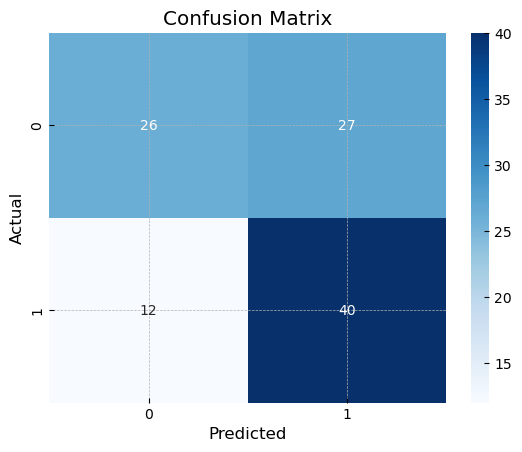

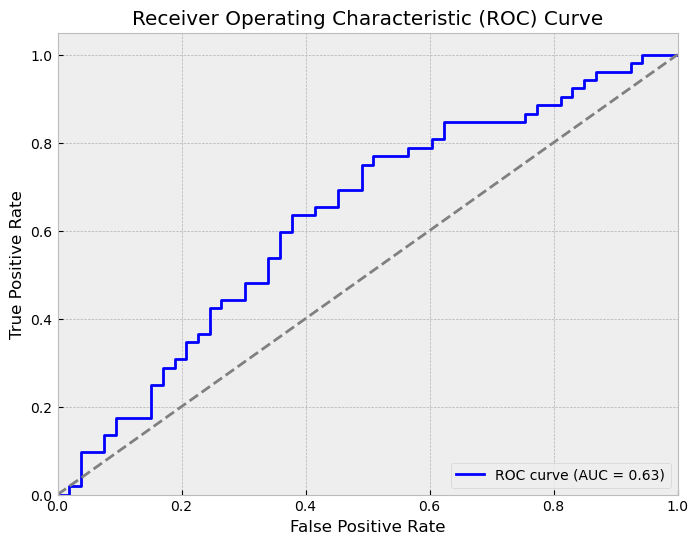

              precision    recall  f1-score   support

           0       0.68      0.49      0.57        53
           1       0.60      0.77      0.67        52

    accuracy                           0.63       105
   macro avg       0.64      0.63      0.62       105
weighted avg       0.64      0.63      0.62       105



In [12]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

In [13]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()

         Current function value: 1.714336
         Iterations: 35


In [14]:
number_of_significant_features = (results.pvalues < .05).sum() # 42

In [15]:
number_of_significant_features

42

In [16]:
results.pvalues[results.pvalues < .05].sort_values().head(15)

sunrise_dusk            0.00
low_bnd_avglow_vol5d    0.00
close_bnd               0.00
close_ief close_gdaxi   0.00
close_bnd close_gdaxi   0.00
close_bnd close_ief     0.00
low_ief_avglow_vol5d    0.00
anomaly                 0.00
close_bnd_avgvol5d      0.00
close_bnd_day1          0.00
close_ief_day1          0.00
low_bnd_day7            0.00
low_gld_avglow_vol5d    0.00
close_spy_day1          0.00
open_spy                0.00
dtype: float64

In [17]:
tree_based_feature_importances = utils.Tools.get_tree_model_feature_importances(xgb_model, X_train.columns)

In [18]:
tree_based_feature_importances.head(15)

savgol_close_gdaxi_w10_p3    0.03
non_business_days_in_month   0.02
low_spy_avglow_vol5d         0.02
business_days_in_month       0.01
year_days_left               0.01
month_first_day              0.01
close_ief_avgspy_corr30d     0.01
close_gdaxi_kmomentum        0.01
close_ief_avgspy_corr10d     0.01
sunrise_dusk                 0.01
savgol_close_gdaxi_w10_p2    0.01
year_days_passed             0.01
close_bnd close_gdaxi        0.01
close_ief_avggdaxi_corr10d   0.01
close_bnd_avggdaxi_corr10d   0.01
dtype: float32

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [50]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [46]:
scores = list()
for train_index, test_index in cts.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
    scores.append(
        roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
    )

TRAIN: 866 TEST: 866
TRAIN: 866 TEST: 866
TRAIN: 866 TEST: 866


In [49]:
baseline_score = np.array(scores).mean()
baseline_score

0.6251646232349765

In [30]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

In [61]:
big_step, small_step = 10, 5
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)
number_of_features = X_train.columns.shape[0] - big_step
step = big_step
current_score = baseline_score

progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
    try:
        RFE_FEATURES = _RFE_FEATURES.copy()
    except NameError:
        RFE_FEATURES = X_train.columns
    
    rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
    rfe.fit(X_train, y_train)
    
    rfe.fit(X_train, y_train)
    _RFE_FEATURES = X_train.columns[rfe.support_]
    
    scores = list()
    for train_index, test_index in cts.split(X_train):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

        scores.append(
            roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
        )

    current_score = np.array(scores).mean()
    
    if number_of_features < 100:
        step = small_step
        
    number_of_features = number_of_features - step
    progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
    progress_bar.update(step)

progress_bar.close()

Processing (AUC: 0.5982):  12%|██████▋                                                | 30/249 [06:08<44:51, 12.29s/it]


In [73]:
baseline_score - 0.5982

0.026964623234976504

In [63]:
RFE_FEATURES

Index(['low_bnd', 'low_gld', 'low_ief', 'low_spy', 'low_gdaxi', 'high_bnd',
       'high_gld', 'high_ief', 'high_spy', 'high_gdaxi',
       ...
       'close_bnd close_gld', 'close_bnd close_ief', 'close_bnd close_spy',
       'close_bnd close_gdaxi', 'close_gld close_ief', 'close_gld close_spy',
       'close_gld close_gdaxi', 'close_ief close_spy', 'close_ief close_gdaxi',
       'close_spy close_gdaxi'],
      dtype='object', length=229)

In [83]:
# rfe = RFE(estimator=xgb_model, n_features_to_select=40)

# rfe.fit(X_train, y_train)
# RFE_FEATURES = X_train.columns[rfe.support_]

# RFE_FEATURES

Collinearity

<Axes: >

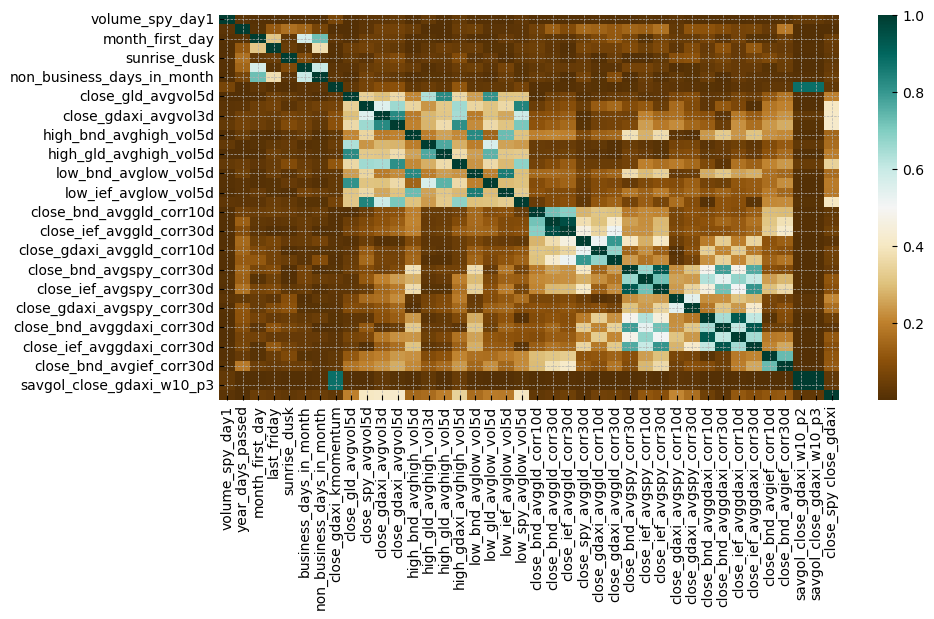

In [86]:
plt.figure(figsize=(10,5))
c= X_train[RFE_FEATURES].corr().abs()
sns.heatmap(c,cmap="BrBG",annot=False)

VIF

In [65]:
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train[RFE_FEATURES].columns 
vif_data["VIF"] = [variance_inflation_factor(X_train[RFE_FEATURES].values, i) 
                          for i in range(len(X_train[RFE_FEATURES].columns))]
vif_data.sort_values('VIF', ascending=False).head(10)

,feature,VIF
133,business_days_in_month,inf
127,month_days_passed,inf
128,month_days_left,inf
134,non_business_days_in_month,inf
211,savgol_close_gdaxi_w10_p2,15258913408.37
217,savgol_close_gdaxi_w10_p3,15258810009.81
212,savgol_close_bnd_w5_p3,8259492203.99
202,savgol_close_bnd_w5_p2,8259363450.48
213,savgol_close_ief_w5_p3,2919776878.73
206,savgol_close_ief_w5_p2,2919314125.36


In [66]:
def calculate_vifs(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

In [67]:
sub_train = X_train[RFE_FEATURES].copy()

In [68]:
threshold_vif = 5
while True:
    vifs = calculate_vifs(sub_train)
    max_vif = vifs['VIF'].max()
    if max_vif > threshold_vif:
        feature_to_remove = vifs[vifs['VIF'] == max_vif]['feature'].values[0]
        sub_train.drop(columns=[feature_to_remove], inplace=True)
        print(f"Removed {feature_to_remove} with VIF={max_vif}")
    else:
        break

# print("Remaining features and VIFs:")
# print(calculate_vifs(sub_train))

Removed month_days_passed with VIF=inf
Removed savgol_close_gdaxi_w10_p2 with VIF=15258913408.37145
Removed savgol_close_bnd_w5_p3 with VIF=8090032293.613976
Removed savgol_close_ief_w5_p3 with VIF=1663905114.753894
Removed savgol_close_gdaxi_w5_p2 with VIF=379033591.9660035
Removed year_days_left with VIF=91305.04613596726
Removed savgol_close_ief_w10_p2 with VIF=62405.54517677775
Removed business_days_in_month with VIF=7874.130170440406
Removed savgol_close_spy_w5_p3 with VIF=1321.669623335817
Removed high_gdaxi with VIF=588.191150700665
Removed low_gdaxi with VIF=373.01112586741056
Removed volume_gdaxi_kmomentum with VIF=272.9756128550774
Removed close_gdaxi_kmomentum with VIF=236.3004757741927
Removed open_gdaxi_kmomentum with VIF=77.94024993332013
Removed close_ief with VIF=67.91699921200427
Removed close_ief_avgspy_corr30d with VIF=58.57603334145844
Removed close_ief_avggdaxi_corr30d with VIF=29.769075359429316
Removed close_ief_day1 with VIF=29.489386137098087
Removed savgol_clo

In [69]:
VIF_KEPT_FEATURES = calculate_vifs(sub_train).feature.values
VIF_KEPT_FEATURES

array(['high_ief', 'high_spy', 'open_bnd', 'open_gld', 'open_spy',
       'open_gdaxi', 'volume_bnd', 'volume_gld', 'volume_ief',
       'volume_spy', 'volume_gdaxi', 'high_ief_day1', 'open_bnd_day1',
       'open_gld_day1', 'open_spy_day1', 'open_gdaxi_day1',
       'volume_bnd_day1', 'volume_gld_day1', 'volume_ief_day1',
       'volume_spy_day1', 'volume_gdaxi_day1', 'close_bnd_day1',
       'close_gld_day1', 'close_spy_day1', 'low_bnd_day3',
       'open_gld_day3', 'open_ief_day3', 'open_spy_day3',
       'open_gdaxi_day3', 'volume_bnd_day3', 'volume_gld_day3',
       'volume_ief_day3', 'volume_spy_day3', 'volume_gdaxi_day3',
       'close_gld_day3', 'close_ief_day3', 'close_spy_day3',
       'close_gdaxi_day3', 'low_bnd_day7', 'open_gld_day7',
       'open_ief_day7', 'open_spy_day7', 'open_gdaxi_day7',
       'volume_bnd_day7', 'volume_gld_day7', 'volume_ief_day7',
       'volume_spy_day7', 'volume_gdaxi_day7', 'close_gld_day7',
       'close_ief_day7', 'close_spy_day7', 'close_gda

<Axes: >

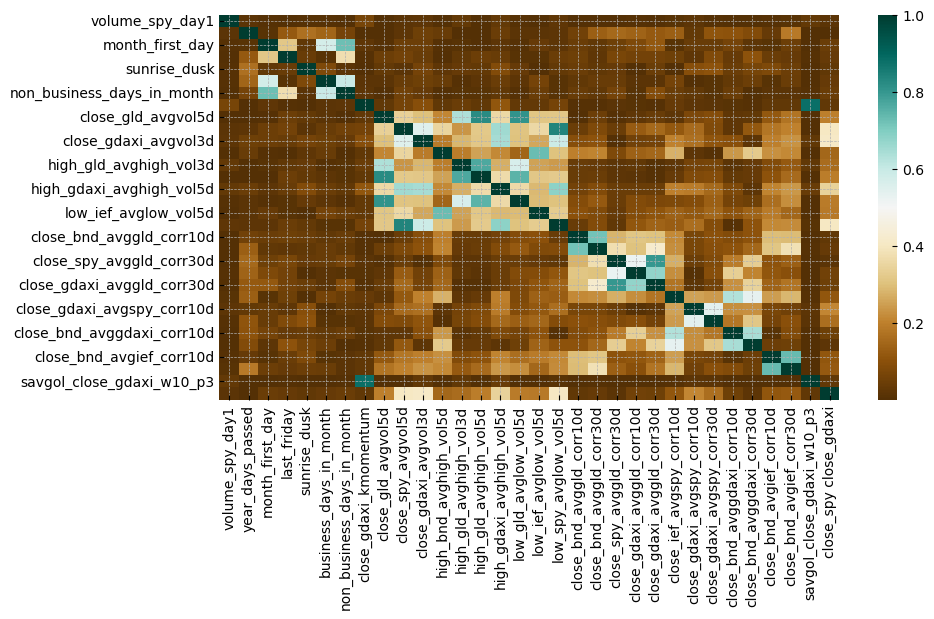

In [94]:
plt.figure(figsize=(10,5))
c = X_train[VIF_KEPT_FEATURES].corr().abs()
sns.heatmap(c,cmap="BrBG",annot=False)

Correlation Clusters

In [96]:
corr = c  # we can consider this as affinity matrix
distances = 1 - corr.abs().values  # pairwise distnces

distArray = ssd.squareform(distances)  # scipy converts matrix to 1d array
hier = hierarchy.linkage(distArray, method="ward")  # you can use other methods

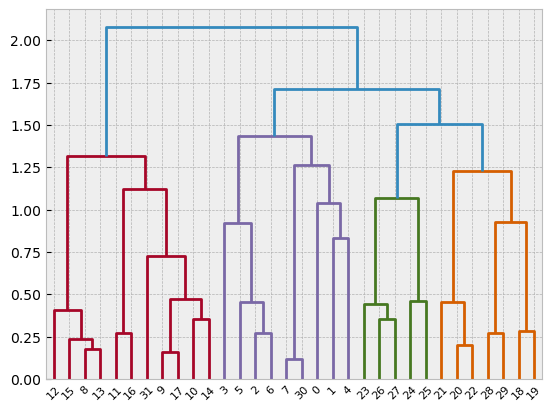

In [100]:
dend = hierarchy.dendrogram(hier, truncate_mode="level", p=30, color_threshold=1.5)

In [101]:
threshold = 1.25  # choose threshold using dendrogram or any other method (e.g. quantile or desired number of features)
cluster_labels = hierarchy.fcluster(hier, threshold, criterion="distance")

In [102]:
cluster_labels

array([5, 5, 3, 3, 5, 3, 3, 4, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 7, 7, 7, 7,
       7, 6, 6, 6, 6, 6, 7, 7, 4, 2], dtype=int32)

In [113]:
cluster_id = 6
c.iloc[np.where(cluster_labels == cluster_id)[0],np.where(cluster_labels == cluster_id)[0]]

,close_ief_avgspy_corr10d,close_gdaxi_avgspy_corr10d,close_gdaxi_avgspy_corr30d,close_bnd_avggdaxi_corr10d,close_bnd_avggdaxi_corr30d
close_ief_avgspy_corr10d,1.00,0.25,0.24,0.63,0.53
close_gdaxi_avgspy_corr10d,0.25,1.00,0.54,0.22,0.23
close_gdaxi_avgspy_corr30d,0.24,0.54,1.00,0.18,0.31
close_bnd_avggdaxi_corr10d,0.63,0.22,0.18,1.00,0.64
close_bnd_avggdaxi_corr30d,0.53,0.23,0.31,0.64,1.00


Test Feature Set

In [70]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train[VIF_KEPT_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [71]:
y_prob = xgb_model.predict_proba(X_test[VIF_KEPT_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

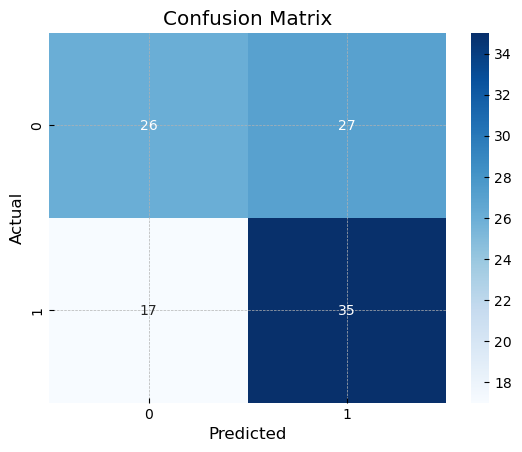

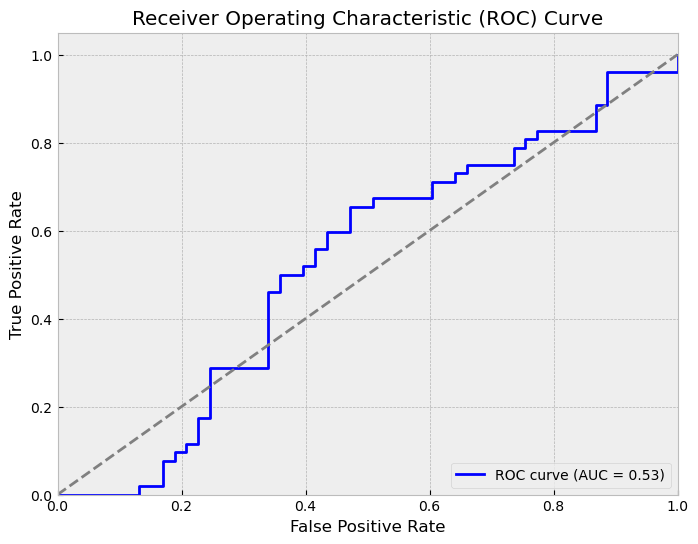

              precision    recall  f1-score   support

           0       0.60      0.49      0.54        53
           1       0.56      0.67      0.61        52

    accuracy                           0.58       105
   macro avg       0.58      0.58      0.58       105
weighted avg       0.58      0.58      0.58       105



In [72]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

Dimensionality reduction

In [148]:
dr_train = list()
dr_test = list()

pca_models = list()
for cluster_id in range(1, max(cluster_labels) + 1):
    cluster_group = c.iloc[np.where(cluster_labels == cluster_id)[0],:].index
    pca = PCA(n_components=2)
    pca.fit(X_train[cluster_group])
    pca_models.append(
        {'features' : cluster_group, 'model': pca }
    )
    
    _train = pd.DataFrame(pca.transform(X_train[cluster_group]), columns=range(0,2), index=X_train.index)
    _test = pd.DataFrame(pca.transform(X_test[cluster_group]), columns=range(0,2), index=X_test.index)
    
    dr_train.append(_train)
    dr_test.append(_test)
    
    print(cluster_id, "explained variance", sum(pca.explained_variance_ratio_))

1 explained variance 0.9145673310330277
2 explained variance 0.7138344663677182
3 explained variance 0.8486053075695611
4 explained variance 1.0
5 explained variance 0.7221615797321549
6 explained variance 0.7508490938451977
7 explained variance 0.6914632498229123


In [ ]:
dr_train = pd.concat(dr_train, axis=1)
dr_train.columns = range(dr_train.columns.shape[0])

In [159]:
dr_test = pd.concat(dr_test, axis=1)
dr_test.columns = range(dr_test.columns.shape[0])

In [161]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(dr_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [162]:
y_prob = xgb_model.predict_proba(dr_test)
_optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

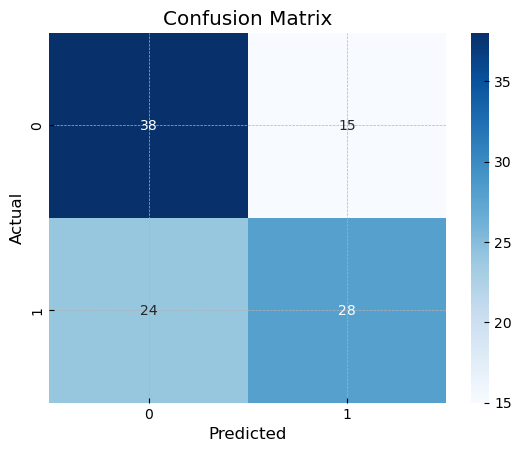

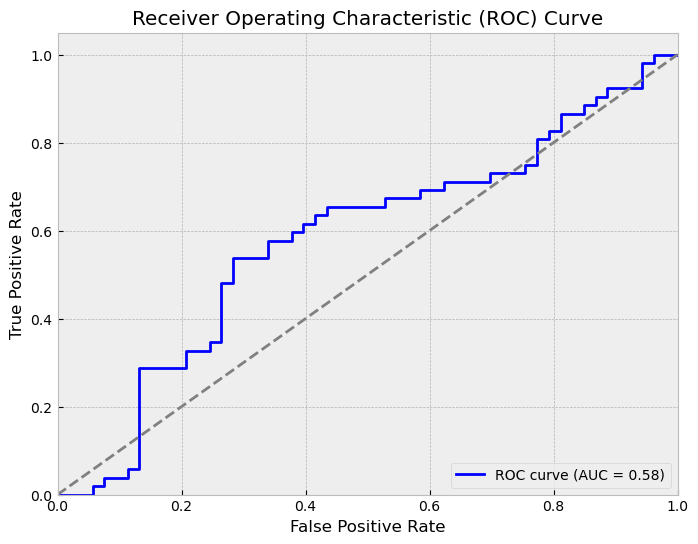

              precision    recall  f1-score   support

           0       0.61      0.72      0.66        53
           1       0.65      0.54      0.59        52

    accuracy                           0.63       105
   macro avg       0.63      0.63      0.63       105
weighted avg       0.63      0.63      0.63       105



In [163]:
utils.Tools.performance_report(y_test, y_prob, _optimal_threshold)

### Hyperparam optimization

In [168]:
def objective_xgboost_classification(X_train, y_train, trial):

    _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 1100),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }

    
    # Initialize the XGBoost classifier model with hyperparameters
    model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return score 

In [169]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train, y_train)
study_xgboost_classification.optimize(objective, n_trials=100)

[I 2024-06-20 16:19:19,989] A new study created in memory with name: no-name-5ee26116-6882-4343-aa55-355426fecacb
[I 2024-06-20 16:19:35,093] Trial 0 finished with value: 0.5999154474490798 and parameters: {'n_estimators': 1070, 'max_depth': 9, 'learning_rate': 0.026965344905286136, 'subsample': 0.9575589522535116, 'colsample_bytree': 0.8012346955265345, 'gamma': 0.02761337941130868, 'min_child_weight': 9, 'reg_alpha': 0.056109500067187235, 'reg_lambda': 0.014201984775552987}. Best is trial 0 with value: 0.5999154474490798.
[I 2024-06-20 16:19:47,056] Trial 1 finished with value: 0.6084122238830759 and parameters: {'n_estimators': 928, 'max_depth': 18, 'learning_rate': 0.04746949697308452, 'subsample': 0.805842105830306, 'colsample_bytree': 0.9701295389609557, 'gamma': 0.0855513509868406, 'min_child_weight': 7, 'reg_alpha': 0.03296327010035868, 'reg_lambda': 0.011710490480337676}. Best is trial 1 with value: 0.6084122238830759.
[I 2024-06-20 16:20:09,922] Trial 2 finished with value: 0

[I 2024-06-20 16:25:44,075] Trial 20 finished with value: 0.6159653334541227 and parameters: {'n_estimators': 928, 'max_depth': 15, 'learning_rate': 0.005917064316610608, 'subsample': 0.5862579095192678, 'colsample_bytree': 0.8195763925798903, 'gamma': 0.07465352477905457, 'min_child_weight': 6, 'reg_alpha': 0.0914775624232319, 'reg_lambda': 0.06320754327795947}. Best is trial 12 with value: 0.621514094608265.
[I 2024-06-20 16:26:11,517] Trial 21 finished with value: 0.6283915387054401 and parameters: {'n_estimators': 932, 'max_depth': 17, 'learning_rate': 0.0021561608426896948, 'subsample': 0.6053527456561115, 'colsample_bytree': 0.827531045059713, 'gamma': 0.07503077283716637, 'min_child_weight': 6, 'reg_alpha': 0.09319129325092337, 'reg_lambda': 0.07234182445120138}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:26:44,741] Trial 22 finished with value: 0.6140100557140916 and parameters: {'n_estimators': 966, 'max_depth': 17, 'learning_rate': 0.0001928772479662351

[I 2024-06-20 16:32:17,968] Trial 40 finished with value: 0.5943553622925819 and parameters: {'n_estimators': 1057, 'max_depth': 15, 'learning_rate': 0.09495470162100056, 'subsample': 0.5781222841628031, 'colsample_bytree': 0.8522545085861399, 'gamma': 0.06564576490613, 'min_child_weight': 7, 'reg_alpha': 0.055007988718315776, 'reg_lambda': 0.053999407969976175}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:32:34,598] Trial 41 finished with value: 0.6079026437770833 and parameters: {'n_estimators': 903, 'max_depth': 18, 'learning_rate': 0.013413713632154553, 'subsample': 0.6081578356078207, 'colsample_bytree': 0.8404567096589343, 'gamma': 0.0740538629730473, 'min_child_weight': 7, 'reg_alpha': 0.08825346192208292, 'reg_lambda': 0.06027696501983517}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:32:54,992] Trial 42 finished with value: 0.6083971252132687 and parameters: {'n_estimators': 921, 'max_depth': 17, 'learning_rate': 0.009445324865878, 's

[I 2024-06-20 16:38:10,880] Trial 60 finished with value: 0.6188416300523925 and parameters: {'n_estimators': 915, 'max_depth': 16, 'learning_rate': 0.009814349822320781, 'subsample': 0.7004082157939547, 'colsample_bytree': 0.8058386379224775, 'gamma': 0.08129393922976032, 'min_child_weight': 9, 'reg_alpha': 0.0710650755095419, 'reg_lambda': 0.038308682998086124}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:38:34,462] Trial 61 finished with value: 0.6179659072035754 and parameters: {'n_estimators': 910, 'max_depth': 17, 'learning_rate': 0.002675102257834414, 'subsample': 0.827147606629963, 'colsample_bytree': 0.8205365540578482, 'gamma': 0.06821247924202753, 'min_child_weight': 9, 'reg_alpha': 0.06095528911454874, 'reg_lambda': 0.03418252837790012}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:38:54,867] Trial 62 finished with value: 0.6134891516057436 and parameters: {'n_estimators': 920, 'max_depth': 17, 'learning_rate': 0.004196154644922238

[I 2024-06-20 16:44:48,332] Trial 80 finished with value: 0.6024406999743321 and parameters: {'n_estimators': 970, 'max_depth': 14, 'learning_rate': 0.01775859331263348, 'subsample': 0.6764290910877411, 'colsample_bytree': 0.8347262922567892, 'gamma': 0.09228566593974621, 'min_child_weight': 8, 'reg_alpha': 0.009075059061825963, 'reg_lambda': 0.050309955118043925}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:45:09,174] Trial 81 finished with value: 0.611541423200616 and parameters: {'n_estimators': 952, 'max_depth': 15, 'learning_rate': 0.00012117672982462236, 'subsample': 0.6318512147641091, 'colsample_bytree': 0.8479780047560678, 'gamma': 0.08776959909835175, 'min_child_weight': 9, 'reg_alpha': 0.01898384893859882, 'reg_lambda': 0.03312106775921911}. Best is trial 21 with value: 0.6283915387054401.
[I 2024-06-20 16:45:28,546] Trial 82 finished with value: 0.617580891123492 and parameters: {'n_estimators': 962, 'max_depth': 16, 'learning_rate': 0.0035907540645268

In [170]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best AUC: 0.6283915387054401
Best Hyperparameters: {'n_estimators': 932, 'max_depth': 17, 'learning_rate': 0.0021561608426896948, 'subsample': 0.6053527456561115, 'colsample_bytree': 0.827531045059713, 'gamma': 0.07503077283716637, 'min_child_weight': 6, 'reg_alpha': 0.09319129325092337, 'reg_lambda': 0.07234182445120138}


In [184]:
os.listdir('..')

['.git',
 '.gitignore',
 'db',
 'env',
 'open_notebook.bat',
 'proof_of_concept',
 'README.md',
 'requirements.txt',
 'src']

In [185]:
os.makedirs('../config', exist_ok=True)

In [186]:
config = {
    'selected_features' : list(VIF_KEPT_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

In [189]:
with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

Best parameters

In [190]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[VIF_KEPT_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.827531045059713, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.07503077283716637,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0021561608426896948,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=932, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [191]:
y_prob = xgb_model.predict_proba(X_test[VIF_KEPT_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

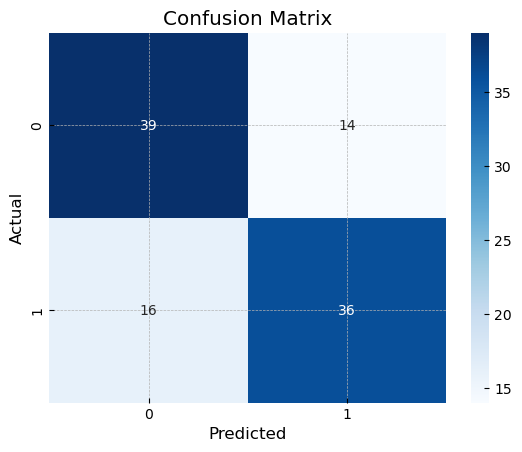

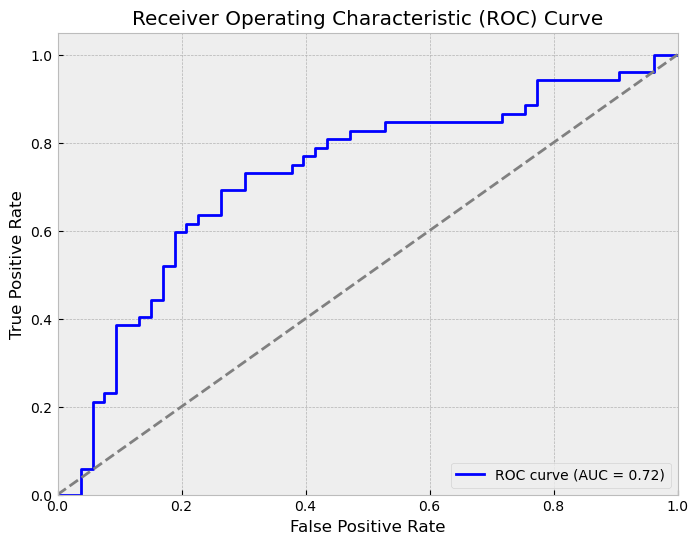

              precision    recall  f1-score   support

           0       0.71      0.74      0.72        53
           1       0.72      0.69      0.71        52

    accuracy                           0.71       105
   macro avg       0.71      0.71      0.71       105
weighted avg       0.71      0.71      0.71       105



In [192]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

In [31]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>